# ANN, excluding Cys-epitopes

In [1]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

%load_ext autoreload
%autoreload 2

2025-04-01 20:03:14.773416: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 20:03:14.780173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743552194.788732  120562 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743552194.791467  120562 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 20:03:14.800325: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## dataset

In [2]:
infile = '/home/yuan/results/epitope/epi_top_features.txt'
df = pd.read_csv(infile, sep='\t', header=0, index_col=None)
# balance the number of epitopes and non-epitopes
# shuffle rows
df = df.sample(frac=1)
df.head()

,seq,label,mean_hydro_ph7,mean_hydro,mean_polar,mean_polar_stab,mean_VDWV,median_hydro_ph7,median_hydro,median_polar,...,has_N,has_D,has_C,has_I,has_L,has_K,has_F,has_T,has_Y,has_V
524115,WCGACGVYARDRDSN,1,16.333333,0.772,8.700000,0.145533,3.118667,0.0,0.600,9.0,...,1,1,1,0,0,0,0,0,1,1
1321461,HPDNRIRLML,1,21.800000,1.074,8.470000,0.196100,4.180000,-3.0,0.895,9.2,...,1,1,0,1,1,0,0,0,0,0
2154049,HYIQLGTVYR,1,39.500000,1.016,7.740000,0.191700,4.128000,38.0,0.965,7.4,...,0,0,0,1,1,0,0,1,1,1
1144393,NLKKGEGKKNEKNEE,1,-15.066667,0.632,10.893333,0.152467,3.454667,-23.0,0.470,11.3,...,1,0,0,0,1,1,0,0,0,0
1244925,VAIDHSLSLA,1,39.400000,0.899,7.890000,0.124900,2.764000,41.0,0.610,8.1,...,0,1,0,1,1,0,0,0,0,1


## train: without Cys

In [3]:
# keep epitopes without Cys
feature = 'has_C'
print('entire data:', df.shape)
print('epitopes without Cys:', df[(df[feature]==0) & (df['label']==1)].shape)
print('epitopes having Cys:', df[(df[feature]==1) & (df['label']==1)].shape)
# sub_df = df[~((df[feature]==1) & (df['label']==1))]
sub_df = df[df[feature]==0]
print('filtered data:', sub_df.shape)

entire data: (2490831, 48)
epitopes without Cys: (1586519, 48)
epitopes having Cys: (212276, 48)
filtered data: (2120189, 48)


In [4]:
from my_ann import MyAnn

# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (2120189, 46) float16
y: (2120189,) float16
labels: Counter({np.float16(1.0): 1586519, np.float16(0.0): 533670})
train data: (1187305, 46) (1187305,)
validate data: (508846, 46) (508846,)
test data (424038, 46) (424038,)


In [5]:
c.declare_model()

I0000 00:00:1743552204.711083  120562 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9107 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        24,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,409 (286.75 KB)

 Trainable params: 73,409 (286.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
# train model
c.train(epochs=10)

Epoch 1/10


I0000 00:00:1743552206.112356  120690 service.cc:148] XLA service 0x79b82c002390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743552206.112372  120690 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-04-01 20:03:26.139624: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743552206.217512  120690 cuda_dnn.cc:529] Loaded cuDNN version 90800


  180/37104 ━━━━━━━━━━━━━━━━━━━━ 31s 847us/step - accuracy: 0.7231 - auc: 0.5786 - loss: 0.5889 - mse: 0.1979 - precision: 0.7498 - recall: 0.9337

I0000 00:00:1743552206.797810  120690 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37104/37104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7610 - auc: 0.6963 - loss: 0.5176 - mse: 0.1698 - precision: 0.7719 - recall: 0.9659

E0000 00:00:1743552246.486041  120690 buffer_comparator.cc:157] Difference at 16: 0, expected 260.803
E0000 00:00:1743552246.486065  120690 buffer_comparator.cc:157] Difference at 17: 0, expected 274.951
E0000 00:00:1743552246.486067  120690 buffer_comparator.cc:157] Difference at 18: 0, expected 253.659
E0000 00:00:1743552246.486068  120690 buffer_comparator.cc:157] Difference at 19: 0, expected 257.607
E0000 00:00:1743552246.486070  120690 buffer_comparator.cc:157] Difference at 20: 0, expected 250.262
E0000 00:00:1743552246.486071  120690 buffer_comparator.cc:157] Difference at 21: 0, expected 258.782
E0000 00:00:1743552246.486072  120690 buffer_comparator.cc:157] Difference at 22: 0, expected 253.591
E0000 00:00:1743552246.486073  120690 buffer_comparator.cc:157] Difference at 23: 0, expected 258.759
E0000 00:00:1743552246.486075  120690 buffer_comparator.cc:157] Difference at 24: 0, expected 259.406
E0000 00:00:1743552246.486077  120690 buffer_comparator.cc:157] Difference at 25: 

37104/37104 ━━━━━━━━━━━━━━━━━━━━ 57s 1ms/step - accuracy: 0.7610 - auc: 0.6963 - loss: 0.5176 - mse: 0.1698 - precision: 0.7719 - recall: 0.9659 - val_accuracy: 0.7700 - val_auc: 0.7227 - val_loss: 0.5019 - val_mse: 0.1637 - val_precision: 0.7821 - val_recall: 0.9604
Epoch 2/10
37104/37104 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.7693 - auc: 0.7231 - loss: 0.5029 - mse: 0.1639 - precision: 0.7815 - recall: 0.9602 - val_accuracy: 0.7734 - val_auc: 0.7367 - val_loss: 0.5011 - val_mse: 0.1625 - val_precision: 0.8028 - val_recall: 0.9245
Epoch 3/10
37104/37104 ━━━━━━━━━━━━━━━━━━━━ 50s 1ms/step - accuracy: 0.7735 - auc: 0.7324 - loss: 0.4960 - mse: 0.1612 - precision: 0.7871 - recall: 0.9562 - val_accuracy: 0.7777 - val_auc: 0.7409 - val_loss: 0.4921 - val_mse: 0.1589 - val_precision: 0.8000 - val_recall: 0.9375
Epoch 4/10
37104/37104 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step - accuracy: 0.7752 - auc: 0.7369 - loss: 0.4937 - mse: 0.1603 - precision: 0.7896 - recall: 0.9538 - val_accuracy: 0.

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.763870,0.707254,0.511732,0.167487,0.774635,0.965229,0.770019,0.722725,0.501909,0.163696,0.782096,0.960409
1,0.770630,0.726010,0.500992,0.163151,0.783483,0.958268,0.773425,0.736666,0.501060,0.162544,0.802790,0.924477
2,0.773583,0.733803,0.495866,0.161134,0.787455,0.955225,0.777683,0.740907,0.492097,0.158910,0.799952,0.937510
3,0.775134,0.737483,0.493451,0.160176,0.789722,0.953302,0.778682,0.742304,0.488239,0.158079,0.793097,0.953017
4,0.775441,0.739885,0.492047,0.159647,0.790643,0.951948,0.774893,0.741968,0.496858,0.160405,0.805516,0.921923
5,0.775721,0.741314,0.491141,0.159355,0.791253,0.951196,0.776944,0.744586,0.488603,0.158349,0.801433,0.933318
6,0.776298,0.742954,0.490154,0.158970,0.792112,0.950474,0.776763,0.743939,0.489813,0.158619,0.807893,0.920784
7,0.776597,0.743697,0.489644,0.158760,0.792276,0.950681,0.773831,0.742130,0.492703,0.160033,0.807731,0.915944
8,0.776618,0.744072,0.489437,0.158710,0.792461,0.950337,0.776137,0.745084,0.491004,0.159052,0.808373,0.918800
9,0.776830,0.745104,0.488809,0.158455,0.792797,0.950032,0.774336,0.744050,0.496234,0.160505,0.814920,0.903875


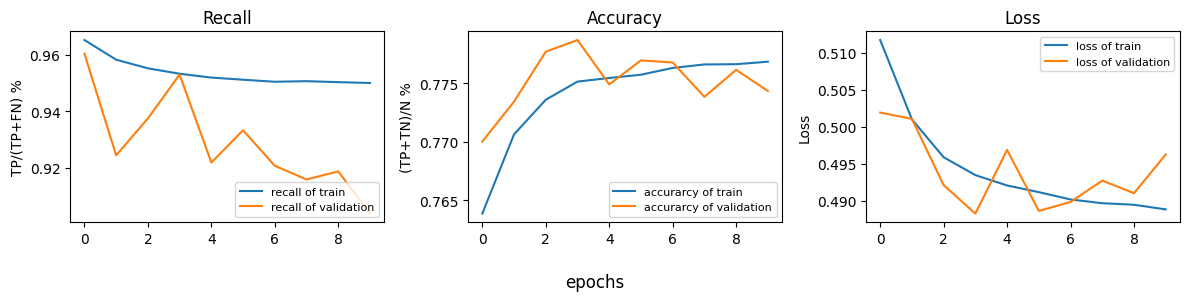

In [7]:
# evaluate model
c.plot_acc_recall()

In [8]:
# evaluate model using test data
c.test()

13243/13252 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.7729 - auc: 0.7430 - loss: 0.4976 - mse: 0.1610 - precision: 0.8133 - recall: 0.9037

E0000 00:00:1743552794.503310  120690 buffer_comparator.cc:157] Difference at 16: -0.834961, expected 267.091
E0000 00:00:1743552794.503333  120690 buffer_comparator.cc:157] Difference at 17: -0.334961, expected 265.399
E0000 00:00:1743552794.503334  120690 buffer_comparator.cc:157] Difference at 18: -0.701172, expected 273.023
E0000 00:00:1743552794.503336  120690 buffer_comparator.cc:157] Difference at 19: -1.2793, expected 244.155
E0000 00:00:1743552794.503337  120690 buffer_comparator.cc:157] Difference at 20: -1.09473, expected 254.107
E0000 00:00:1743552794.503338  120690 buffer_comparator.cc:157] Difference at 21: 3.50977, expected 250.956
E0000 00:00:1743552794.503340  120690 buffer_comparator.cc:157] Difference at 22: -0.756348, expected 259.578
E0000 00:00:1743552794.503341  120690 buffer_comparator.cc:157] Difference at 23: 0.466797, expected 257.408
E0000 00:00:1743552794.503342  120690 buffer_comparator.cc:157] Difference at 24: 0.255859, expected 259.096
E0000 00:00:17435

13252/13252 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.7729 - auc: 0.7430 - loss: 0.4976 - mse: 0.1610 - precision: 0.8133 - recall: 0.9037
{'accuracy': 0.7725274562835693, 'auc': 0.7427527904510498, 'loss': 0.4979970157146454, 'mse': 0.16121822595596313, 'precision': 0.8135027885437012, 'recall': 0.9028700590133667}
13252/13252 ━━━━━━━━━━━━━━━━━━━━ 5s 357us/step
[[0.7946871 ]
 [0.8549349 ]
 [0.58072615]]


array([[0.7946871 ],
       [0.8549349 ],
       [0.58072615],
       ...,
       [0.65761447],
       [0.86608213],
       [0.8801609 ]], shape=(424038, 1), dtype=float32)

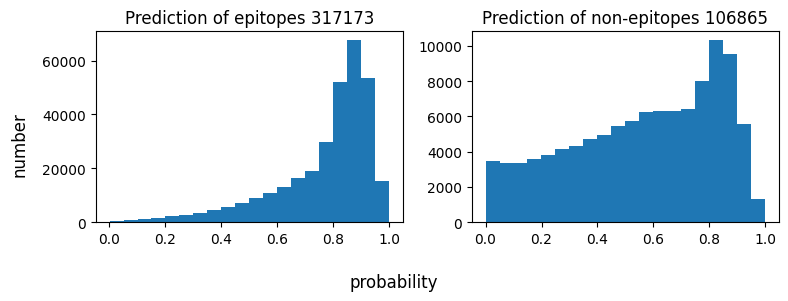

In [9]:
c.plot_prob()

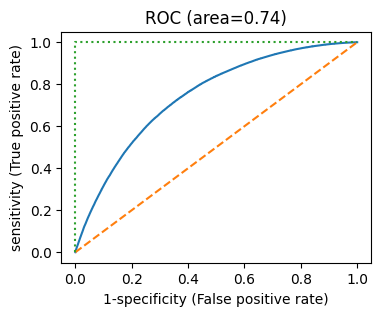

In [10]:
c.plot_roc()

In [11]:
# save entire model
c.save_model('../models/epitopes_ann_notCys.keras')

<Sequential name=sequential, built=True>